# HW8: Object Detection

In this exercise we will implement a couple of modern object detection methods:
1. Viola-Jones fast face detection with binary features and adaptive boosting
1. Object detector based on YOLO and a convolutional neural network

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tqdm # progress bar
import requests, zipfile, io, os, glob, json
from PIL import Image
import tensorflow as tf

In [ ]:
tf.config.list_physical_devices('GPU')

## Face Detection with Viola-Jones

We're going to create our very own Viola-Jones-ish **face detector** with Haar-like binary features and an **AdaBoost classifier based on 1-level Decision Trees** (basically a single split based on a single feature).

Load the data: (based on the [FDDB](http://vis-www.cs.umass.edu/fddb/))

In [ ]:
id = '1SLI12ggbnM_f9ZfZa0Bed-1GYwzuMOvV'
dl_url = f'https://drive.google.com/uc?id={id}&export=download&confirm=t'

if not os.path.exists('faces_db.npz'):
    # download and show progress bar
    print('Downloading faces_db.npz...')
    with open('faces_db.npz', 'wb') as f:
        request = requests.get(dl_url, stream=True)
        total_length = int(request.headers.get('content-length'))
        for chunk in tqdm.tqdm(request.iter_content(chunk_size=1024), total=total_length/1024, unit='KB'):
            if chunk:
                f.write(chunk)
                f.flush()


data = np.load('faces_db.npz')
faces = data['faces']
not_faces = data['not_faces']

### Faces

In [ ]:
plt.figure(figsize=(20,10))
for i in range(160):
    plt.subplot(10,16,i+1)
    plt.imshow(faces[np.random.randint(0,len(faces))], cmap='gray')
    plt.xticks([]),plt.yticks([])

### Not Faces

In [ ]:
plt.figure(figsize=(20,10))
for i in range(160):
    plt.subplot(10,16,i+1)
    plt.imshow(not_faces[np.random.randint(0,len(not_faces))], cmap='gray')
    plt.xticks([]),plt.yticks([])

Put all samples (positive + negative) in a single array and create a binary annotation {0,1}:

In [ ]:
X_faces = np.vstack([faces, not_faces])
y_faces = np.array([1] * len(faces) + [0] * len(not_faces))

### Create Haar-like binary features
Randomize 1000 Haar-like binary features:
1. Randomize width & height (range [min,max] = [10,30])
1. Randomize feature type: horizontal/vertical + 2-split/3-split (total 4 types)
1. Randomize x,y (make sure not exceed image bounds)

In [ ]:
# util function to draw a Haar-like feature
def draw_haar_feature(im, haar_feature):
    x,y,w,h,ft = haar_feature
    x1,y1 = x + w, y + h
    xmid,ymid = int(x+w/2.),  int(y+h/2.)
    x13,y13   = int(x+w/3.),  int(y+h/3.)
    x23,y23   = int(x+2*w/3.),int(y+2*h/3.)
    assert(ft < 4 and ft >= 0)

    if ft == 0:
        cv2.rectangle(im, (x,y),    (x1,ymid), (0,255,0), cv2.FILLED)
        cv2.rectangle(im, (x,ymid), (x1,y1), (255,0,0), 1)
    if ft == 1:
        cv2.rectangle(im, (x,y),    (xmid,y1), (0,255,0), cv2.FILLED)
        cv2.rectangle(im, (xmid,y), (x1,y1), (255,0,0), 1)
    if ft == 2:
        cv2.rectangle(im, (x,y),   (x1,y13), (255,0,0), 1)
        cv2.rectangle(im, (x,y13), (x1,y23), (0,255,0), cv2.FILLED)
        cv2.rectangle(im, (x,y23), (x1,y1), (255,0,0), 1)
    if ft == 3:
        cv2.rectangle(im, (x,y),   (x13,y1), (255,0,0), 1)
        cv2.rectangle(im, (x13,y), (x23,y1), (0,255,0), cv2.FILLED)
        cv2.rectangle(im, (x23,y), (x1,y1), (255,0,0), 1)
    return im

In [ ]:
NUM_HAAR_FEATURES = 1000

Randomize the feature coordinates:

In [ ]:
haar_features_im = np.zeros((48,48,3),np.uint8)
haar_features = []

plt.figure(figsize=(20,10))
np.random.seed(42) # make sure results are repeatable
for i in range(NUM_HAAR_FEATURES):
    # randomly sample a Haar-like feature: (x,y,w,h,feature_type)
    # use np.random.randint to sample x,y,w,h, and use np.random.choice to sample feature_type
    w = np.random.randint(1, 49)  # ensure width is at least 1 and at most 48
    h = np.random.randint(1, 49)  # ensure height is at least 1 and at most 48
    x = np.random.randint(0, 48 - w + 1)  # ensure x + w does not exceed 48
    y = np.random.randint(0, 48 - h + 1)  # ensure y + h does not exceed 48
    ft = np.random.choice(4)
    haar_features.append((x,y,w,h,ft))

    # show the first 45 Haar-like features
    if i < 45:
        plt.subplot(3,15,i+1)
        plt.imshow(draw_haar_feature(haar_features_im.copy(), haar_features[-1]))
        plt.xticks([]),plt.yticks([])
plt.tight_layout()

### Calculate responses
Calculate the feature responses for all samples, using the integral image.
Create a dataset of shape: (\[num_samples\], 1000)

"The sum of the pixels within rectangle D can be computed with four array references. The value of the integral image at location 1 is the sum of the pixels in rectangle A, The value at location 2 is A+B, at location 3 is A+C, and at location 4 is A+B+C+D. The sum within D can be computed as 4 + 1 - (2 + 3)."

Note that the different feature types will have a different number of summations.

In [ ]:
# calculate a box sum from the integral image with the top-left corner at (x0,y0) and the bottom-right corner at (x1,y1)
def ii_sum(ii, x0, y0, x1, y1):
    # recall how the integral image is defined and how to calculate the sum of a box from the integral image
    # return ii[]...
    sum = ii[y1][x1] - ii[y1][x0] - ii[y0][x1] + ii[y0][x0]
    
    return sum

# extract Haar-like features from the image
def extract_haar_features(imgray, haar_features_, ii=None):
    # calculate the integral image if not provided using cv2.integral
    ii = cv2.integral(imgray) if ii is None else ii

    feature_responses = []
    for (x0,y0,w,h,ft) in haar_features_:
        # get the feature response for each Haar-like feature
        # get bottom-right corners of the feature
        x1, y1 = x0 + w, y0 + h
        # get the midpoints of the feature in x and y
        xmid, ymid = x0 + w // 2, y0 + h // 2
        # get the 1/3 and 2/3 points of the feature
        x13, y13 = x0 + w // 3, y0 + h // 3
        x23, y23 = x0 + 2 * w // 3, y0 + 2 * h // 3

        # calculate the feature response based on the feature type (0 - horizontal 2-split, 1 - vertical 2-split, 2 - horizontal 3-split, 3 - vertical 3-split)
        if ft == 0:  # Horizontal 2-split
            left_sum = ii_sum(ii, x0, y0, xmid, y1)
            right_sum = ii_sum(ii, xmid, y0, x1, y1)
            feature_response = left_sum - right_sum
        
        if ft == 1:  # Vertical 2-split
            top_sum = ii_sum(ii, x0, y0, x1, ymid)
            bottom_sum = ii_sum(ii, x0, ymid, x1, y1)
            feature_response = top_sum - bottom_sum
        
        if ft == 2:  # Horizontal 3-split
            left_sum = ii_sum(ii, x0, y0, x13, y1)
            middle_sum = ii_sum(ii, x13, y0, x23, y1)
            right_sum = ii_sum(ii, x23, y0, x1, y1)
            feature_response = left_sum - 2 * middle_sum + right_sum
        
        if ft == 3:  # Vertical 3-split
            top_sum = ii_sum(ii, x0, y0, x1, y13)
            middle_sum = ii_sum(ii, x0, y13, x1, y23)
            bottom_sum = ii_sum(ii, x0, y23, x1, y1)
            feature_response = top_sum - 2 * middle_sum + bottom_sum

        feature_responses.append(feature_response)

    return feature_responses

Since extracting the responses from 1000s of images is a lengthy operation I've added a progress bar:

In [ ]:
X_faces_features = []
for i in tqdm.tqdm(range(len(X_faces))):
    X_faces_features.append(extract_haar_features(X_faces[i], haar_features))

Shuffle and split the dataset to training and testing

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_faces_features, y_faces, random_state=42)

### Create and train an Adaptive Boosting classifier

Define an AdaBoost classifier (`AdaBoostClassifier` from `sklearn.ensemble`) with just 20 estimators (each estimator is a depth-1 decision tree which is `DecisionTreeClassifier` from `sklearn.tree`).

Create the decision tree with `max_depth=1` and the AdaBoost classifier with `n_estimators=20`.

Name the classifier `bdt` (boosted decision trees)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

Define an AdaBoost classifier with just 20 estimators (each estimator is a depth-1 decision tree).

In [ ]:
# TODO: create an AdaBoost classifier with 20 weak learners (Decision Trees with max_depth=1)
bdt = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=20, random_state=42)

Train the model on the training data

In [ ]:
bdt.fit(X_train, y_train)

Show the selected features in each weak classifier: (decreasing order of power)

In [ ]:
plt.figure(figsize=(20,5))
for i in range(20):
    haar_features_im = cv2.cvtColor(X_faces[14],cv2.COLOR_GRAY2RGB).copy()
    draw_haar_feature(haar_features_im, haar_features[bdt.estimators_[i].tree_.feature[0]])
    plt.subplot(2,10,i+1)
    plt.imshow(haar_features_im),plt.title("%d: Feature %d"%(i, bdt.estimators_[i].tree_.feature[0]))
    plt.xticks([]),plt.yticks([])

As you can see the selected features are quite indicative of whether there is a face in the image, mostly concerned with the eyes area.

We can also visualize how much classification error each weak estimator has:

In [ ]:
plt.plot(bdt.estimator_errors_),plt.xticks(range(20));

It's obvious that the first few features are the better ones with minimum error in classification, which is why they were selected first.

We can evaluate our classifier on the test set:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = bdt.predict(X_test)
print("Accuracy:\t",  accuracy_score(y_test, y_pred))
print("Precision:\t", precision_score(y_test, y_pred))
print("Recall:\t\t",  recall_score(y_test, y_pred))
print("F1 score:\t",  f1_score(y_test, y_pred))

The classifier gets a pretty high F1 score ($\sim$ 0.88), which means it is well balanced between precision and recall.

### Hyperparameter Tuning
Let's try to find the optimal number of estimators, since 20 is pretty arbitrary.

Using a "Grid Search" we can test different values of the parameter.

Use `sklearn.model_selection`'s `GridSearchCV` to test out value for `n_estimators` of the `AdaBoostClassifier`.
Try out the following values: 15, 20, 30, 50, 80

Read on how to do this at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [15, 20, 30, 50, 80]}]

# create an AdaBoost classifier with Decision Trees with max_depth=1 like before
adb_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1))
# use GridSearchCV to find the best number of weak learners
grid_search = GridSearchCV(adb_clf, param_grid, cv=2, verbose=3, n_jobs=-1)

grid_search.fit(X_train, y_train)

Which is the best model?

In [ ]:
grid_search.best_estimator_.n_estimators

As expected the 80-features model is the best, with the highest accuracy. If we would have increased that number futher we would expect to see some overfitting.

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test)
print("Accuracy:\t",  accuracy_score(y_test, y_pred))
print("Precision:\t", precision_score(y_test, y_pred))
print("Recall:\t\t",  recall_score(y_test, y_pred))
print("F1 score:\t",  f1_score(y_test, y_pred))

However, the added benefit of the 60 additional features (!!) over our 20-features model translates to just 0.02 increase in F1, which is neglegible. We can probably do just as well with the 15-features model as well, and gain a significant speed boost.

### Detect faces in an image
To detect a face, simply run the classifier over a $50\times50$ sliding window in the image.

In [ ]:
import PIL
import urllib.request

In [ ]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Solvay_conference_1927.jpg/1024px-Solvay_conference_1927.jpg'
im = cv2.resize(np.array(PIL.Image.open(urllib.request.urlopen(url))), (0,0), fx=1.2, fy=1.2)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(im, cmap='gray');

This is the famous 1927 Solvay Conference picture that features some the finest phyicists of the time like Einstien, Bohr, Schrödinger, Dirac, Marie Curie, Planck, and others.

Now, instead of calculating all of the 1000 Haar-like features, we need only to calculate the ones selected by our 20-feature classifier. But - we need to place them in the right position in the 1000-long feature vector so that the classifier will pick them up (as if all of the 1000 were calculated).

This will immensly increase the calculation time, having to evaluate the response for just 20 features instead of 1000.

In [ ]:
X_faces_features = np.array(X_faces_features)

# this is the complete list of features, shape (N, 1000)
X_faces_features.shape

In [ ]:
# TODO: Gather just the 20 selected features/"estimators" (from the original `bdt` classifier) and their index in the original 1000-long vector
haar_features_selected_index = [est.tree_.feature[0] for est in bdt.estimators_] # get the feature index
# extract the selected features from the original X_faces_features
X_faces_features_selected = np.array(X_faces_features)[:, haar_features_selected_index]

# also store the selected features "description" (x,y,w,h,type) in the `haar_features_selected` array
# taken from the original haar_features array.
haar_features_selected = np.array(haar_features)[haar_features_selected_index]

In [ ]:
# this is the reduced list of features, expected shape: (N, 18)
X_faces_features_selected.shape

In [ ]:
# split the data into training and testing sets
X_train_select, X_test_select, y_train_select, y_test_select = train_test_split(
    X_faces_features_selected, y_faces, test_size=0.2, random_state=42
)

In [ ]:
# TODO: re-train the classifier on just the selected features
# create a new AdaBoost classifier with 20 weak learners (Decision Trees with max_depth=1)
bdt = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=1), n_estimators=20, random_state=42)
bdt.fit(X_train_select, y_train_select)

y_pred = bdt.predict(X_test_select)
print("Accuracy:\t",  accuracy_score(y_test_select, y_pred))
print("Precision:\t", precision_score(y_test_select, y_pred))
print("Recall:\t\t",  recall_score(y_test_select, y_pred))
print("F1 score:\t",  f1_score(y_test_select, y_pred))

In [ ]:
imgray = im.copy()

# TODO: detect faces in the image `im` using the selected features
# equalize histogram, compute integral image, and loop over the image with a sliding window
# of size 50x50 with a stride of 10 pixels. for each window, crop the integral image to 50x50.
# extract the features responses for the selected features using the
# `extract_haar_features_responses` function (which expects input of size 50x50).
# and use the classifier to predict the face/non-face class. use `.predict_proba`
# and a threshold (I used 0.5) to determine if a positive detection is made.
# store the detections in the `detections` list, each detection is a tuple (x,y,pred_prob)

# equalize histogram and calculate integral image
im_eq = cv2.equalizeHist(imgray)
ii = cv2.integral(im_eq)
imdebug = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)

# loop over the image with a sliding window of size 50x50 and stride of 10 pixels
for x in range(0, im.shape[1] - 50, 10):
    for y in range(0, im.shape[0] - 50, 10):
        # crop the integral image to the 50x50 window using the top-left corner at (x,y)
        crop = ii[y : y + 50, x : x + 50]
        # extract the features responses for the selected features using the `extract_haar_features` function on `crop`
        features = extract_haar_features(crop, haar_features_selected, ii=crop)
        # predict using the re-trained classifier
        pred = bdt.predict_proba([features])
        # take only high-confidence predictions (try to tweak the threshold)
        if pred[0, 1] > 0.54:
            cv2.rectangle(imdebug, (x, y), (x + 50, y + 50), (255, 0, 0), 1)
            cv2.putText(
                imdebug,
                "%.2f" % pred[0, 1],
                (x, y + 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                2,
            )
plt.figure(figsize=(10, 10))
plt.imshow(imdebug)

How about that for a face detector? Based on just 20 binary features, it's pretty nifty...

The actual method further speeds thing up by running each weak estimator in order and breaking early if chances are low to get a positive prediction.

## Object detection with YOLO
We will now implement a very simple single-stage object detector, which follows the YOLO (v1) scheme [[Redmon 2016](https://arxiv.org/abs/1506.02640)].

As a backbone we will use MobileNetV3 [[Howard 2019](https://arxiv.org/abs/1905.02244v5)], which is a highly efficient conv net geared at realtime applications on mobile devices. It's very small, just a couple million of parameters, which lets it run very fast on modest hardware.

#### Download dataset

I've prepared a dataset of cats and dogs with bounding box annotation.

In [106]:
id = '1H5d-9C0u_nQd3HjKgdi9DqHBeg0bYuL_'
dl_url = f'https://drive.usercontent.google.com/download?id={id}&export=download&confirm=t'

if not os.path.exists('catsdogs_detection/2008_000019.jpg'):
    # download and show progress bar
    print('Downloading data.zip...')
    # download_file_from_google_drive(id, 'data.zip')
    with open('data.zip', 'wb') as f:
        request = requests.get(dl_url, stream=True)
        total_length = int(request.headers.get('content-length'))
        for chunk in tqdm.tqdm(request.iter_content(chunk_size=1024), total=total_length/1024, unit='KB'):
            if chunk:
                f.write(chunk)
                f.flush()

    # extract zip file and show progress bar
    print('Extracting data.zip...')
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        for file in tqdm.tqdm(zip_ref.namelist(), total=len(zip_ref.namelist())):
            zip_ref.extract(file)

    # remove the zip file
    os.remove('data.zip')

### Preparing the data for learning

To make it simple to work with the data, I've written a few functions to help you prepare the data for training and provide a tf.data.Dataset object.

Follow along and run the code below to prepare the data.

Note how we prepare the data in the YOLO 7x7 grid format, with each grid cell responsible for predicting a single object.

According to the paper we need to predict 5 values for each grid cell:
1. $p_o$ - objectness score
1. $b_x, b_y, b_w, b_h$ - bounding box coordinates
1. $c_1, c_2$ - class probabilities (one-hot encoded)

Also note the width and height of the bounding box are normalized by the image width and height to [0, 1] range, and then square-rooted (to give more importance to small boxes, e.g. 0.25 -> 0.5).

In [107]:
import json
import math
import os
import cv2
import numpy as np
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

output_shape = (224, 224)  # Output shape for YOLO model
grid_size = 7  # Adjust based on your YOLO configuration
class_mapping = {'dog': 0, 'cat': 1}
num_classes=2

def convert_bboxes_to_yolo_grid(bboxes, orig_image_shape):
    """
    Convert bounding boxes to YOLO format.

    Parameters:
    - bboxes: A list of bounding boxes in the format provided by your JSON
              Each bounding box is in the format ["class_label", [x_min, y_min, x_max, y_max]]
    - image_shape: The shape of the preprocessed image (height, width, channels)
    - grid_size: The size of the grid that the image is divided into

    Returns:
    - A (grid_size x grid_size) tensor of bounding boxes
      For each bounding box: [norm_center_x, norm_center_y, norm_width, norm_height, objectness, <class one hot>]
      where coordinates and sizes are normalized to [0, 1] by the grid cell size and image size respectively
    """
    yolo_grid = np.zeros((grid_size, grid_size, 5 + num_classes))  # Initialize YOLO grid

    for bbox in bboxes:
        class_label, (x_min, y_min, x_max, y_max) = bbox

        # Convert class label to class ID (assuming class_mapping is a global dict)
        class_id = class_mapping.get(class_label, -1)

        # Calculate center coordinates and size of bounding boxes
        center_x = (x_min + x_max) / 2.0
        center_y = (y_min + y_max) / 2.0
        width = float(x_max - x_min)
        height = float(y_max - y_min)

        # Normalize coordinates and sizes by image size
        norm_center_x = center_x / orig_image_shape[1]
        norm_center_y = center_y / orig_image_shape[0]
        norm_width = width / orig_image_shape[1]
        norm_height = height / orig_image_shape[0]

        # Calculate grid cell indices
        grid_x = min(math.floor(norm_center_x * float(grid_size)), grid_size - 1)
        grid_y = min(math.floor(norm_center_y * float(grid_size)), grid_size - 1)

        # Normalize coordinates to grid cell
        norm_center_x = (norm_center_x * grid_size) - grid_x
        norm_center_y = (norm_center_y * grid_size) - grid_y

        # Normalize width and height with square root
        norm_width = np.sqrt(norm_width)
        norm_height = np.sqrt(norm_height)

        # one-hot encode class
        class_onehot = np.zeros(num_classes)
        class_onehot[class_id] = 1

        # Append to results in YOLO format
        yolo_grid[grid_y, grid_x] = [norm_center_x, norm_center_y, norm_width, norm_height, 1] + class_onehot.tolist()

    return yolo_grid

def convert_yolo_grid_to_bboxes(yolo_grid, image_shape, threshold=0.5):
    """
    Convert YOLO grid to bounding boxes.

    Parameters:
    - yolo_grid: A (grid_size x grid_size) tensor of bounding boxes
      For each bounding box: [norm_center_x, norm_center_y, norm_width, norm_height, objectness, <class one hot>]
    - image_shape: The shape of the preprocessed image (height, width, channels)
    - grid_size: The size of the grid that the image is divided into

    Returns:
    - A list of bounding boxes in the format ["class_label", [x_min, y_min, x_max, y_max]]
    """
    bboxes = []

    for grid_y in range(grid_size):
        for grid_x in range(grid_size):
            box = yolo_grid[grid_y, grid_x]

            # Skip empty bounding boxes
            if box[4] < threshold:
                continue

            # Calculate bounding box coordinates
            center_x = (grid_x + box[0]) / grid_size
            center_y = (grid_y + box[1]) / grid_size
            width = box[2] ** 2
            height = box[3] ** 2

            x_min = int((center_x - width / 2) * image_shape[1])
            y_min = int((center_y - height / 2) * image_shape[0])
            x_max = int((center_x + width / 2) * image_shape[1])
            y_max = int((center_y + height / 2) * image_shape[0])

            bboxes.append([np.argmax(box[5:]), [x_min, y_min, x_max, y_max]])

    return bboxes

def parse_json_file(json_path, image_size):
    with tf.io.gfile.GFile(json_path.numpy(), 'r') as f:
        data = json.load(f)
    yolo_grid = convert_bboxes_to_yolo_grid(data, image_size)
    return yolo_grid.squeeze()

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image_size = tf.cast(tf.shape(image)[:-1], tf.float32)
    image = tf.image.resize(image, output_shape)
    image = preprocess_input(image)
    return image, image_size

def load_and_preprocess(image_path, json_path):
    image, image_size = preprocess_image(image_path)
    yolo_grid = tf.py_function(func=parse_json_file, inp=[json_path, image_size], Tout=[tf.float32])
    yolo_grid = tf.squeeze(tf.convert_to_tensor(yolo_grid, dtype=tf.float32))
    yolo_grid.set_shape((grid_size, grid_size, 5 + num_classes))
    # You may need further processing here to convert bboxes to your YOLO format
    return image, yolo_grid

def create_tf_dataset(image_paths, json_paths, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, json_paths))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# visualize the bboxes from yolo_grid
def draw_bbox(image, single_yolo_grid, color=(0, 255, 0)):
    # conver the yolo grid to bboxes
    bboxes = convert_yolo_grid_to_bboxes(single_yolo_grid, image.shape, threshold=0.4)

    for bbox in bboxes:
        class_label, (x_min, y_min, x_max, y_max) = bbox
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(image, str(class_label), (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        # grid cell center
        cv2.circle(image, (int((x_min + x_max) / 2), int((y_min + y_max) / 2)), 3, color, -1)

    return image

#### Visualize some inputs

First read the directory and prepare the `tf.Dataset`s

In [108]:
# Paths to your data
data_dir = 'catsdogs_detection'
image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir) if img.endswith('.jpg')]
json_paths = [os.path.join(data_dir, json_file) for json_file in os.listdir(data_dir) if json_file.endswith('.json')]

# Ensure the paths are sorted so they are aligned
image_paths.sort()
json_paths.sort()

I'm using batch size of 32, however your computer might not be able to handle that. You can reduce the batch size to 16 or 8 if you're running out of memory.

In [109]:
# Create TensorFlow dataset
dataset = create_tf_dataset(image_paths, json_paths, batch_size=32)

In [110]:
dataset_iter = dataset.as_numpy_iterator()

In [111]:
# Example to iterate over the dataset
images, yolo_grid = next(dataset_iter)
print(images.shape, yolo_grid.shape)

(32, 224, 224, 3) (32, 7, 7, 7)


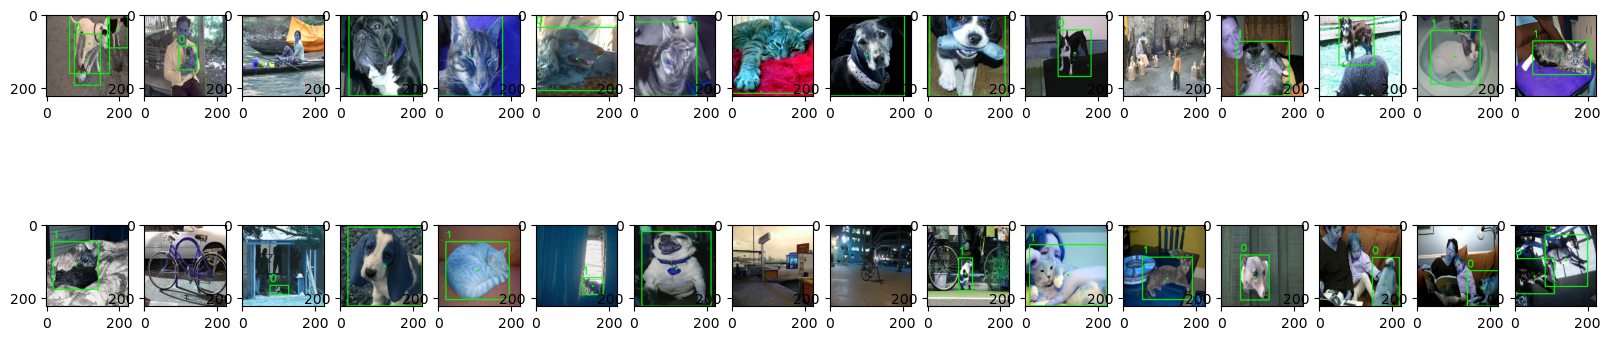

In [112]:
plt.figure(figsize=(20, 5))
# Visualize the predictions
for i in range(images.shape[0]):
    # image = (images[i] + 1) * 127.5
    image = images[i]
    image = image.astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    single_yolo_grid = yolo_grid[i]

    image = draw_bbox(image, single_yolo_grid, color=(0, 255, 0))

    plt.subplot(2, images.shape[0]//2, i + 1)
    plt.imshow(image)

This iterator will produce a single batch in each iteration

### Transfer Learning, Detection model
We want to reuse the MobileNetV3Small model that we get pre-trained for classification.

One way to do so is known as "Transfer Learning", which means we take a model trained on a different dataset for a different problem and transfer it to our problem.

Since the former model is already trained, we can "freeze" the layers already trained and only focus on any new layers we are going to add. This is easily done in Keras by `l.trainable = False` where `l` is a Keras layer.

To build our detection model, we take the classification model and snip off the head (classification parts, e.g. Dense, Flatten, etc.), and connect new layers that will do what we need according to our new problem.

Working with the bounding box grid we set up, we add for each of the 91 bounding boxes:
1. a 1D convolutional layer to reduce the number of channels (from 1024 to 64)
1. A Dense layer to regress, for every grid cell, the BBox (4 params), objectness (1 param) and class (2 params) with 'linear' activation

Finally we must `Reshape()` all the outputs to give us the right shape for the loss function.

In the paper, Redmon et al mention "We use a linear activation function for the final layer". This is because the output of the model is not a probability, but rather a regression of the bounding box parameters. The loss function will take care of the rest.

In [113]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dense, Reshape, Flatten

def yolo_v1_mobilenetv3(input_shape=(224, 224, 3), grid_size=7, num_boxes=1, num_classes=2):
    # Load pre-trained MobileNetV3Small model
    backbone = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freeze the layers of MobileNetV3Small
    for layer in backbone.layers:
        layer.trainable = False
    
    # Extend the model, take x as the output of the backbone (.output)
    x = backbone.output
    
    # add a 1x1 Convolutional Layer with 64 filters and LeakyReLU activation (negative_slope=0.1)
    # use the Conv2D function with 64 filters and a kernel size of (1, 1)
    x = Conv2D(64, (1, 1))(x)
    
    # and then apply LeakyReLU activation with a negative slope of 0.1
    x = LeakyReLU(negative_slope=0.1)(x)
    
    # flatten the output of the previous layer to prepare for the dense layer
    # use the Flatten function
    x = Flatten()(x)
    
    # Final Output Layer
    # create a dense layer of size: grid_size * grid_size * (num_classes + 5 * num_boxes)
    # use the Dense function with the number of units calculated above
    units = grid_size * grid_size * (num_classes + 5 * num_boxes)
    outputs = Dense(units)(x)
    
    # reshape the output to the shape of: (grid_size, grid_size, num_classes + 5 * num_boxes)
    # use the Reshape function
    outputs = Reshape((grid_size, grid_size, num_classes + 5 * num_boxes))(outputs)
    
    # Create the model
    # use the Model function to create a model with backbone.input as the input and outputs as the output
    model = Model(inputs=backbone.input, outputs=outputs)
    
    return model

# Create YOLO model with pre-trained MobileNetV3Small
detection_model = yolo_v1_mobilenetv3()

You may want to inspect the model's architecture with `detection_model.summary()`.

One thing to notice is the number of weights for training. More weights, i.e. a bigger network, are harder to traing while controlling overfitting.

### Custom Multi-task Loss Function
We are trying to detect and classify at once, these are different tasks.

Looking at the original loss definition from YOLO [[Redmon 2016](https://arxiv.org/abs/1506.02640)]:

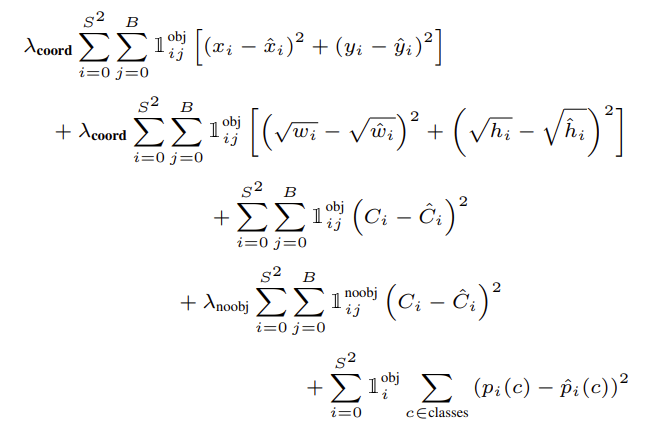

It is a simple sum of the squared errors of the bounding box parameters, the objectness score, and the class prediction.

Let's build that in code:

In [114]:
def yolo_loss(y_true, y_pred):
    """
    YOLO Loss Function.

    Args:
        - y_true: Ground truth labels, tensor of shape (batch_size, grid_size, grid_size, (num_classes + 5) * num_boxes)
        - y_pred: Predictions from the model, same shape as y_true

    Returns:
        - loss: Scalar tensor representing the loss value.

    Each grid cell contains:
        num_boxes * [norm_center_x, norm_center_y, norm_width, norm_height, objectness] + [class_labels one-hot]
    """
    grid_size = 7
    num_boxes = 1
    num_classes = 2
    lambda_coord = 5.0
    lambda_noobj = 0.5

    # Split the predictions and ground truth into components according to the encoding above
    # Predictions (from the y_pred tensor)
    # boxes will be all parameters until the objectness score (e.g. 0-3, up to 4 excluding 4) on the last axis
    # use [..., n] to take all the elements up to n on just the last axis
    pred_boxes = y_pred[..., :4]

    # objectness will be the objectness score in the 5th position (use 4:5 to retain the last dimension)
    pred_objectness = y_pred[..., 4:5]

    # classes will be the one-hot encoded class labels starting from the 6th position (after the objectness score)
    pred_classes = y_pred[..., 5:]

    # Ground Truth
    # do the same for the ground truth (y_true)
    true_boxes = y_true[..., :4]
    true_objectness = y_true[..., 4:5]
    true_classes = y_true[..., 5:]

    # -- Class loss
    # this is the sum of the squared differences between the true and predicted class labels
    # use tf.square and tf.reduce_sum, and multiply by the true objectness score as the indicator
    # make sure to add `axis=[1, 2, 3]` to sum across the grid cells! (and do this for all the summations below)
    # in other words, only calculate the class loss if there is an object in the grid cell, i.e. the objectness score is 1
    # otherwise, the class loss is 0
    class_loss = tf.reduce_sum(
        tf.square(true_classes - pred_classes),
        axis=[1, 2, 3],
    ) * true_objectness

    # -- Object loss
    # this is the sum of the squared differences between the true and predicted objectness scores
    # use tf.square and tf.reduce_sum again
    obj_loss = tf.reduce_sum(
        tf.square(true_objectness - pred_objectness) * true_objectness, axis=[1, 2, 3]
    )

    # -- No-object loss
    # again the sum of the squared differences between the true and predicted objectness scores
    # but this time, we only calculate the loss if there is no object in the grid cell, i.e. the objectness score is 0
    noobj_loss = tf.reduce_sum(
        tf.square(true_objectness - pred_objectness) * (1-true_objectness),
        axis=[1, 2, 3],
    )

    # -- Size loss
    # hint: i'm using tf.reshape to reshape the boxes to the shape (batch_size, grid_size, grid_size, num_boxes, 4)
    # this makes it easier to calculate the loss
    true_boxes = tf.reshape(true_boxes, (-1, grid_size, grid_size, num_boxes, 4))
    pred_boxes = tf.reshape(pred_boxes, (-1, grid_size, grid_size, num_boxes, 4))

    # calculate the loss for the width and height
    # use tf.square and tf.reduce_sum (dont forget axis=[1, 2, 3])
    # calculate the square of the height and width in separate tf.square calls, as per the formula, and add them together
    box_loss = tf.reduce_sum(
        (
            tf.square(true_boxes[..., 2] - pred_boxes[..., 2])
            + tf.square(true_boxes[..., 3] - pred_boxes[..., 3])
        )
        ,
        axis=[1, 2, 3],
    )* true_objectness

    # calculate the loss for the center x and center y coordinates
    # use tf.square and tf.reduce_sum (dont forget axis=[1, 2, 3])
    # calculate the square of the center x and center y in separate tf.square calls, as per the formula, and add them together
    coord_loss = tf.reduce_sum(
        (
            tf.square(true_boxes[..., 0] - pred_boxes[..., 0])
            + tf.square(true_boxes[..., 1] - pred_boxes[..., 1])
        )
        ,
        axis=[1, 2, 3],
    )* true_objectness

    # -- Total loss
    # sum the losses together
    # mind the lambda_coord and lambda_noobj scaling factors in the right terms
    loss = (
        lambda_coord * (coord_loss + box_loss)
        + obj_loss
        + lambda_noobj * noobj_loss
        + class_loss
    )

    # finally return the total loss - use tf.reduce_mean to get the mean loss across the batch
    return tf.reduce_mean(loss)

### Model Training

We will train the model for 40 epochs, which should be enough to see some progress and hopefully hit the "plateau" where the model stops learning.

We will use the Adam optimizer with a default learning rate.

If you read the paper you will learn that the authors use a copmlex learning rate shedule, which is not implemented here. They also trained for 135 epochs, which is a lot for the big datasets they used! (COCO, PASCAL VOC, etc.)

Our goal here is to create a network that's able to learn the task, rather than create a production ready model.

So we're going to forgo splitting our data into training and validation sets, and just train on the whole dataset.

If you want to create a production ready model, you should split the data into training and validation sets and monitor the validation loss to prevent overfitting.

In [115]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('cats_dogs_detection.best.weights.h5',
                                                monitor='loss',
                                                verbose=0,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                mode='auto')

In [116]:
# train the model for a few epochs
detection_model.compile(optimizer='adam', loss=yolo_loss)

In [122]:
training_history = detection_model.fit(dataset, epochs=40, callbacks=[checkpoint])

Epoch 1/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 5.2315
Epoch 2/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 3.4029
Epoch 3/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 2.6088
Epoch 4/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 2.1378
Epoch 5/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 1.8085
Epoch 6/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 1.5651
Epoch 7/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 1.3795
Epoch 8/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 1.2344
Epoch 9/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 1.1201
Epoch 10/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 1.0317
Epoch 11/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.9707
Epoch 12/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.9564
Epoch 13/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 1.0468
Epoch 14/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 1.2310
Epoch 15/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 1.1431
Epoc

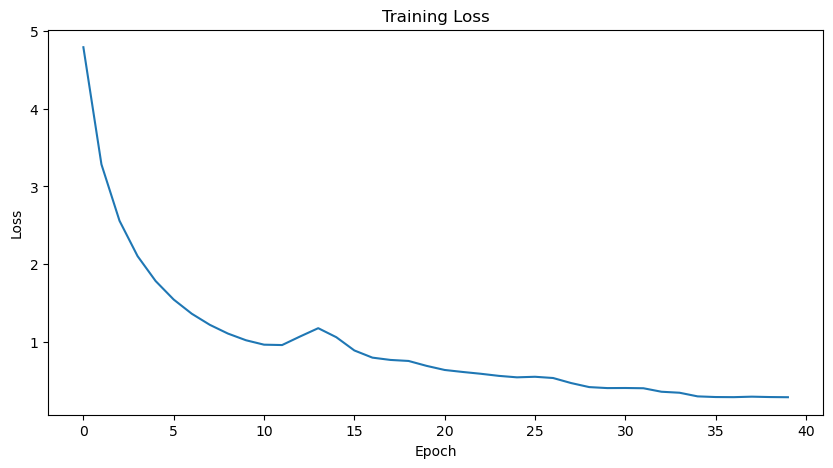

In [123]:
# visualize the training history - loss
plt.figure(figsize=(10, 5))
plt.plot(training_history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Qualitatively evaluate the model

In [124]:
detection_model.load_weights('cats_dogs_detection.best.weights.h5')

In [125]:
images, yolo_grid = dataset_iter.next()
predictions = detection_model(images)

Visualizing the prodections in red and the ground truth in green, we can see that the model is able to detect the objects and classify them correctly.

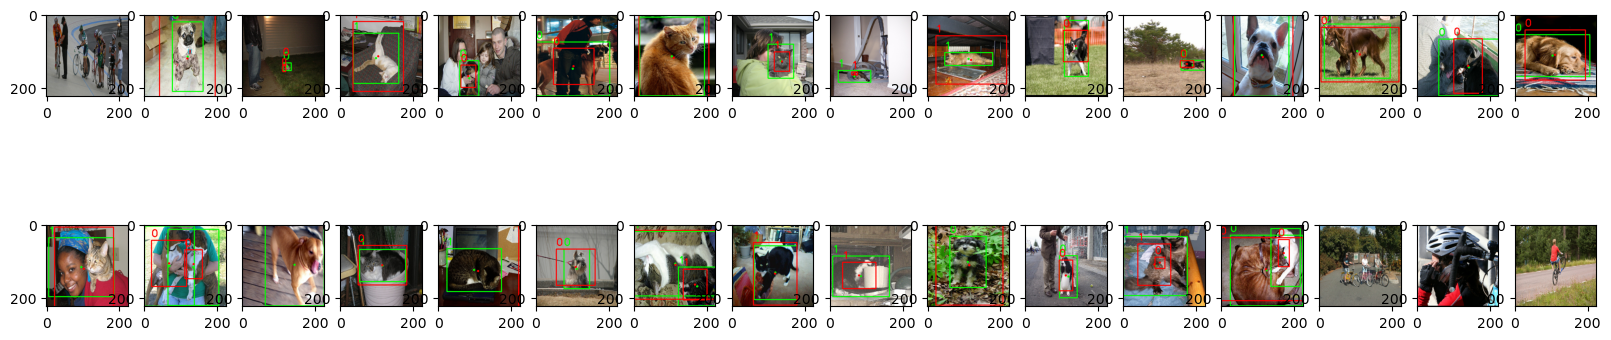

In [126]:
plt.figure(figsize=(20, 5))
# Visualize the predictions
for i in range(images.shape[0]):
    image = images[i]
    image = image.astype(np.uint8)

    single_yolo_grid = yolo_grid[i]
    single_yolo_grid_pred = predictions[i]

    image = draw_bbox(image, single_yolo_grid, color=(0, 255, 0))
    image = draw_bbox(image, single_yolo_grid_pred, color=(255, 0, 0))

    plt.subplot(2, images.shape[0]//2, i + 1)
    plt.imshow(image)

Neat! You created a single stage object detector!

Granted, we are not using the full YOLO architecture, but we are using the same principles and building blocks.
And the architecture is simple enough to understand and modify to your needs.

You can see that the model is able to detect the objects in the image, and even though it's not perfect, it's pretty good for a simple model.

Remeber that we didn't use any data augmentation, regularization, or even a validation set, so the model is likely overfitting.

Still - I'd say this is a pretty cool thing you made!

That's a wrap! Thanks for playing